In [289]:
import psycopg2
from psycopg2 import OperationalError
from psycopg2 import sql
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from scipy.optimize import curve_fit
import seaborn as sns
from IPython.display import HTML
import webbrowser
from collections import defaultdict
import networkx as nx
import csv
import os

os.chdir('/home/francisco/MECAD/2º Ano/Estágio/forcera/scripts/scripts_py')



# LIGAÇÃO À BASE DE DADOS
conn = psycopg2.connect(
    host = "contratos-base-gov1.cf87yxnqgph8.eu-central-1.rds.amazonaws.com",
    port = 5432,
    #database = "contratosbasegov",
    user = "contratosbasegov",
    password = "8n9nyeTBFUyCcLJShNrZdPUai2KQkue4")
cur = conn.cursor()

# PARTE 1 

Construir tabela nova : indicadores estatísticos para concursos públicos por CPV

In [153]:
# Dataframe com CPV(2 digitos), ID e NR_entidadesconcorrentes
cur = conn.cursor()
cur.execute('''
                SELECT cpv2, concursospublicos."id", nr_entidadesconcorrentes
                FROM concursospublicos
                ORDER BY cpv2 DESC;''')

data = pd.DataFrame(cur.fetchall())

In [154]:
CPV = (data.iloc[:,0].unique())
CPV

array(['98', '92', '90', '85', '80', '79', '77', '76', '75', '73', '72',
       '71', '70', '66', '65', '64', '63', '60', '55', '51', '50', '48',
       '45', '44', '43', '42', '41', '39', '38', '37', '35', '34', '33',
       '32', '31', '30', '24', '22', '19', '18', '16', '15', '14', '09',
       '03', '00'], dtype=object)

In [179]:
m = np.zeros([len(CPV),10])
m[:,0] = CPV

for i,j in enumerate(CPV):
    
    res = data.loc[data.iloc[:,0] == j ,data.columns[2]]
    m[i,1] = res.values.sum()
    m[i,2:] = list(res.describe())

In [180]:
m[0,:]

array([9.80000000e+01, 1.73900000e+03, 5.86000000e+02, 2.96757679e+00,
       2.25107152e+00, 1.00000000e+00, 1.00000000e+00, 2.00000000e+00,
       4.00000000e+00, 1.50000000e+01])

In [181]:
table_name = 'cpv_stat'
column_names = ['cpv', 'nec_t', 'count', 'mean', 'std', 'min', 'q1', 'q2', 'q3', 'max']


# Correr apenas uma vez. Caso contrário, adiciona linhas com a mesma info

for row in m:
    insert_query = sql.SQL("INSERT INTO {} ({}) VALUES ({});").format(
        sql.Identifier(table_name),
        sql.SQL(',').join(sql.Identifier(name) for name in column_names),
        sql.SQL(',').join(sql.Literal(value) for value in row)
    )
    cur.execute(insert_query)

conn.commit()

In [109]:
CPV

array(['98', '92', '90', '85', '80', '79', '77', '76', '75', '73', '72',
       '71', '70', '66', '65', '64', '63', '60', '55', '51', '50', '48',
       '45', '44', '43', '42', '41', '39', '38', '37', '35', '34', '33',
       '32', '31', '30', '24', '22', '19', '18', '16', '15', '14', '09',
       '03', '00'], dtype=object)

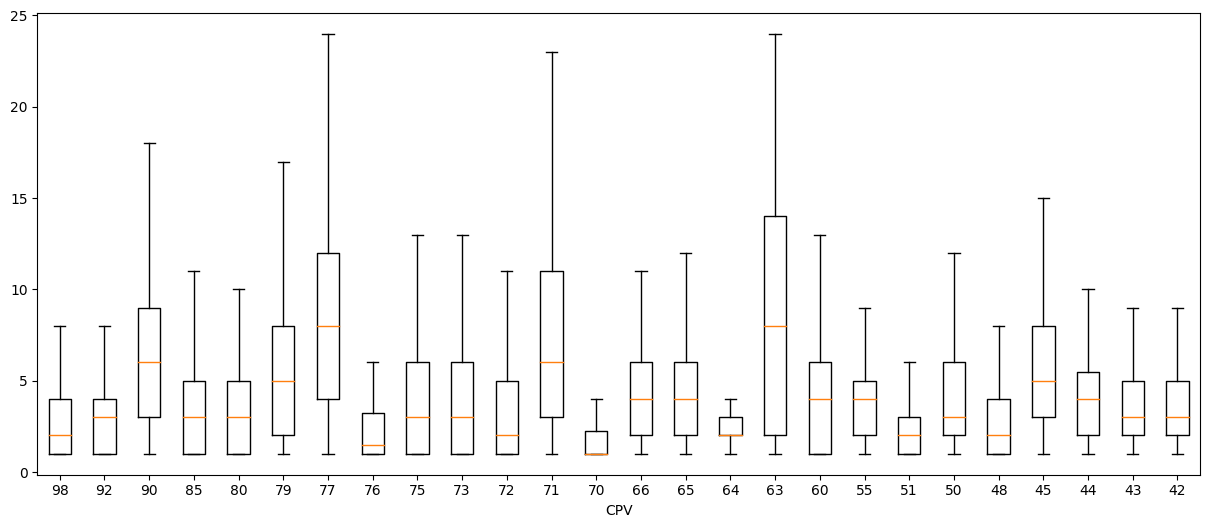

In [145]:
plt.figure(figsize=(15,6))
res1 = [data.loc[data[data.columns[0]] == c, data.columns[2]].values for c in CPV[0:26]]
plt.boxplot(res1, showfliers=False, labels=CPV[0:26])

plt.xlabel('CPV')
plt.savefig('/home/francisco/MECAD/2º Ano/Estágio/tese/tese_pt/imagens/cpv1.png', dpi = 400, bbox_inches='tight')
plt.show()

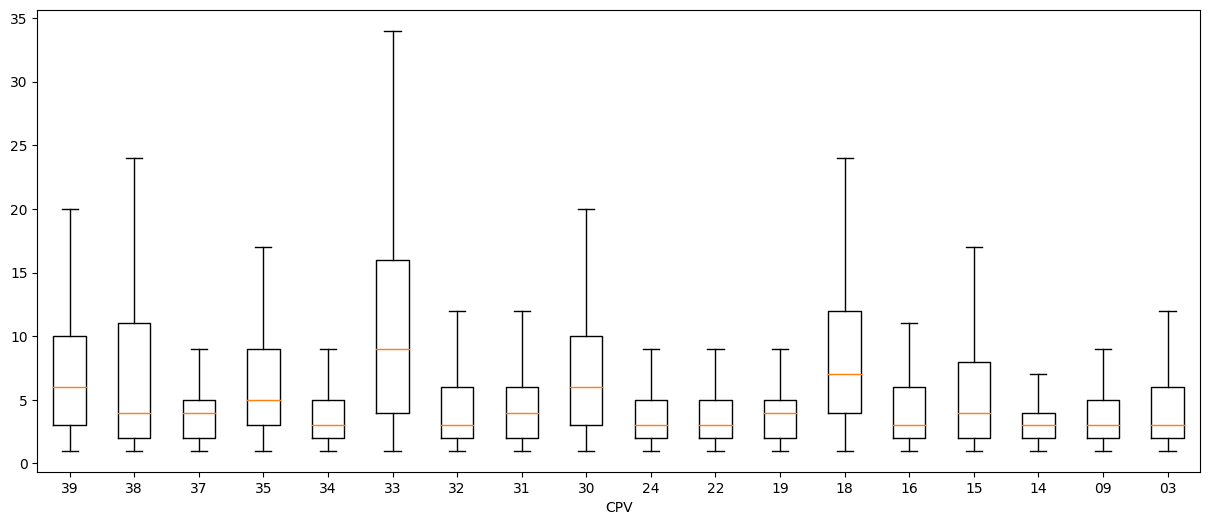

In [146]:
plt.figure(figsize=(15,6))
res1 = [data.loc[data[data.columns[0]] == c, data.columns[2]].values for c in CPV[27:-1]]
plt.boxplot(res1, showfliers=False, labels=CPV[27:-1])

plt.xlabel('CPV')
plt.savefig('/home/francisco/MECAD/2º Ano/Estágio/tese/tese_pt/imagens/cpv2.png', dpi = 400, bbox_inches='tight')
plt.show()

# PARTE 2 

Construir nova tabela com indicadores estatísticos para concursos públicos por CPV e por tipo de contrato

Tipo de contrato tem 3 categorias : 
- Bens e Serviços
- Empreitadas
- Outro

Formato tabela :

- CPV | TipoContrato | NEC Total | NºConcursos | Indicadores Estatísticos

In [194]:
cur = conn.cursor()
cur.execute('''
            SELECT cpv2, tipocontrato, nr_entidadesconcorrentes
            FROM concursospublicos
            ORDER BY cpv2 DESC;
            ''')

data1 = pd.DataFrame(cur.fetchall())

In [195]:
# CONJUNTO DE CPV's
cpv = (data1.iloc[:,0].unique())
cpv

array(['98', '92', '90', '85', '80', '79', '77', '76', '75', '73', '72',
       '71', '70', '66', '65', '64', '63', '60', '55', '51', '50', '48',
       '45', '44', '43', '42', '41', '39', '38', '37', '35', '34', '33',
       '32', '31', '30', '24', '22', '19', '18', '16', '15', '14', '09',
       '03', '00'], dtype=object)

In [208]:
#TIPOS DE CONTRATO
tc = data1.iloc[:,1].unique()
tc

array(['Bens e Serviços', 'Empreitadas', 'Outro'], dtype=object)

In [215]:
# data.loc[data.iloc[:,0] == j ,data.columns[2]]

#data1.loc[data1.iloc[:,0] == '98', data1.iloc[:,1] == 'Bens e Serviços', data.columns[2]]
data1.loc[(data1.iloc[:, 0] == '98') & (data1.iloc[:, 1] == 'Bens e Serviços'), data1.columns[2]].values.sum()


1723

In [249]:
Mm = np.zeros([len(cpv)*3,11], dtype=object)

cpv_rep = np.repeat(cpv,3)
Mm[:,0] = cpv_rep

for i in range(0,len(cpv_rep),3):
    for j in range(3):
        
        Mm[i+j,1] = tc[j]
        
        res = data1.loc[(data1.iloc[:, 0] == cpv_rep[i]) & (data1.iloc[:, 1] == tc[j]), data1.columns[2]]
        
        Mm[i+j,2] = res.values.sum()
        Mm[i+j,3:] = res.describe()


In [268]:
table_name = 'cpv_stat1'
column_names = ['cpv', 'tipocontrato', 'nec_t', 'count', 'mean', 'std', 'min', 'q1', 'q2', 'q3', 'max']


# Correr apenas uma vez. Caso contrário, adiciona linhas com a mesma info
for row in Mm:
    insert_query = sql.SQL("INSERT INTO {} ({}) VALUES ({});").format(
        sql.Identifier(table_name),
        sql.SQL(',').join(sql.Identifier(name) for name in column_names),
        sql.SQL(',').join(sql.Literal(int(value)) if isinstance(value, np.int64) else sql.Literal(value) for value in row)
    )
    cur.execute(insert_query)

conn.commit()

In [275]:
data1.rename(columns={0:'CPV', 1:'Tipo de Contrato', 2:'Values'}, inplace=True)

In [276]:
data1

,CPV,Tipo de Contrato,Values
0,98,Bens e Serviços,1
1,98,Bens e Serviços,5
2,98,Bens e Serviços,1
3,98,Bens e Serviços,2
4,98,Bens e Serviços,4
...,...,...,...
103711,00,Outro,1
103712,00,Outro,1
103713,00,Outro,1
103714,00,Outro,1


In [287]:
res1 = [[data1.loc[(data1['CPV'] == c) & (data1['Tipo de Contrato'] == cc), 'Values'].values for cc in tc] for c in cpv_rep].size > 20
res1

AttributeError: 'list' object has no attribute 'size'

In [286]:
data1

,CPV,Tipo de Contrato,Values
0,98,Bens e Serviços,1
1,98,Bens e Serviços,5
2,98,Bens e Serviços,1
3,98,Bens e Serviços,2
4,98,Bens e Serviços,4
...,...,...,...
103711,00,Outro,1
103712,00,Outro,1
103713,00,Outro,1
103714,00,Outro,1


# PARTE 3

Plots para comparar média, std e mediana por CPV

In [290]:
cur = conn.cursor()
cur.execute('''
                SELECT *
                FROM cpv_stat;''')

tabela = pd.DataFrame(cur.fetchall())

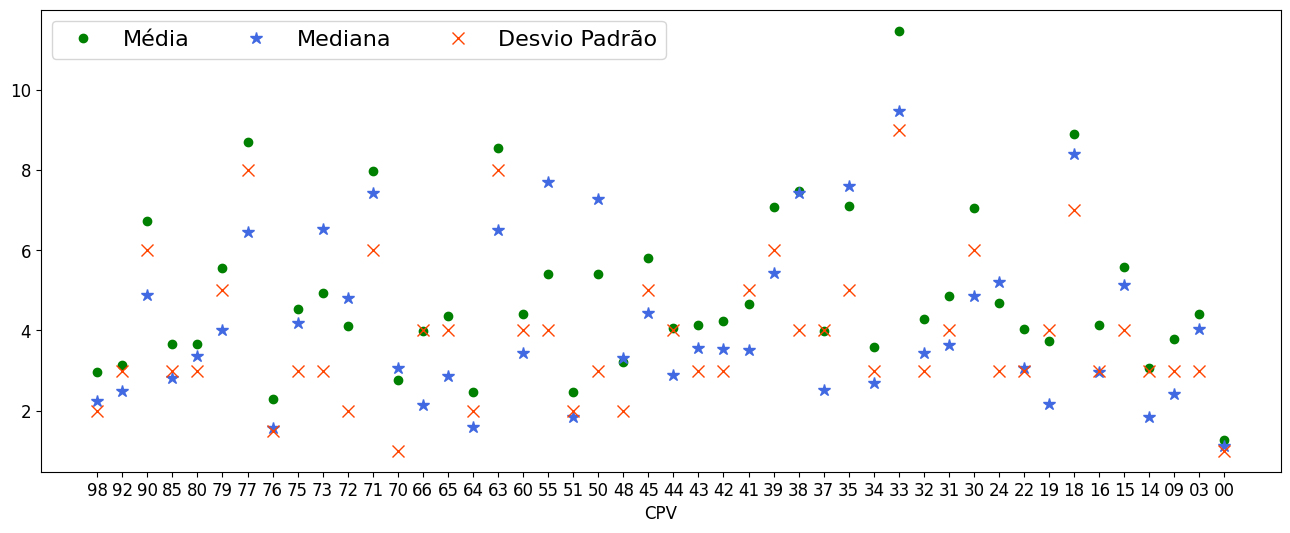

In [362]:
plt.figure(figsize=(16,6))


for i in range(len(tabela)):
    
    cpv = tabela.iloc[i, tabela.columns[0]]
    media = tabela.iloc[i, tabela.columns[3]]
    mediana = tabela.iloc[i, tabela.columns[4]]
    std = tabela.iloc[i, tabela.columns[7]]

    plt.plot(i, media, 'o', color='green', ms = 6, label=f'{cpv}')
    plt.plot(i, mediana, '*', color='royalblue', ms = 9)
    plt.plot(i, std, 'x', color='orangered', ms = 9)

plt.legend(loc='best', labels=['Média', 'Mediana', 'Desvio Padrão'], ncol = 3, fontsize = 16)
plt.xticks(np.arange(len(tabela)), CPV, rotation=0, fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('CPV', fontsize = 12)

#plt.savefig('/home/francisco/MECAD/2º Ano/Estágio/tese/tese_pt/imagens/mmdp.png', dpi = 400, bbox_inches='tight')

plt.show()

# PARTE 4


In [382]:
data = pd.read_csv('/home/francisco/c1.csv')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


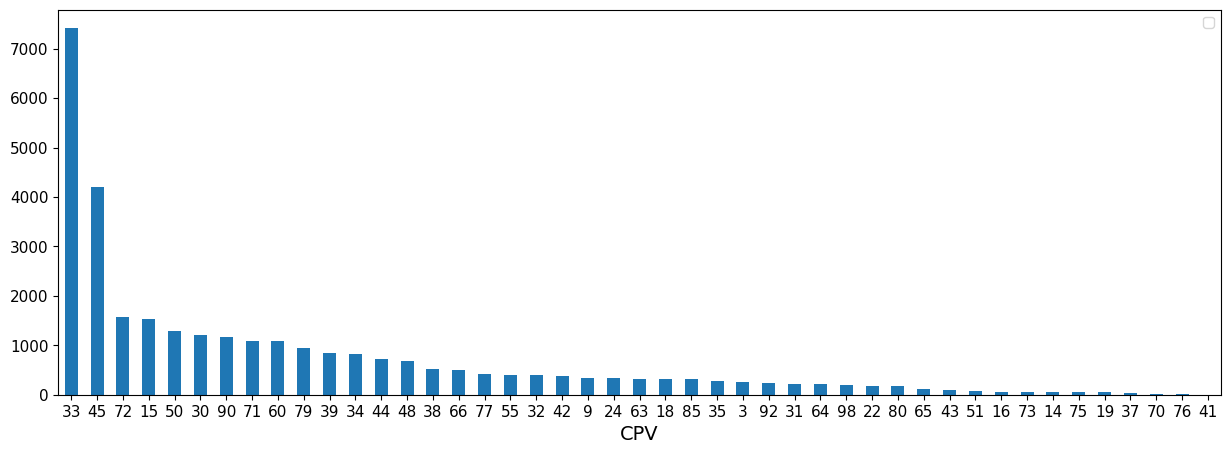

In [427]:
plt.rcParams["figure.figsize"] = (15, 5)

df = pd.DataFrame({'CPV':data.iloc[:,0], 'val':data.iloc[:,1]})
ax = df.plot.bar(x='CPV', y='val', rot=0, label = '')
ax.legend();
ax.set_xlabel('CPV', fontdict={'fontsize':14})
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)

#plt.savefig('/home/francisco/MECAD/2º Ano/Estágio/tese/tese_pt/imagens/r019.png', dpi = 400, bbox_inches='tight')
plt.show()

# PARTE 5 : Barplot R018

In [455]:
data1 = pd.read_csv('/home/francisco/c2.csv')

In [456]:
data1.iloc[:,0].fillna(00, inplace=True)

In [461]:
data1.iloc[:,0] = data1.iloc[:,0].values.astype(int).astype(str)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


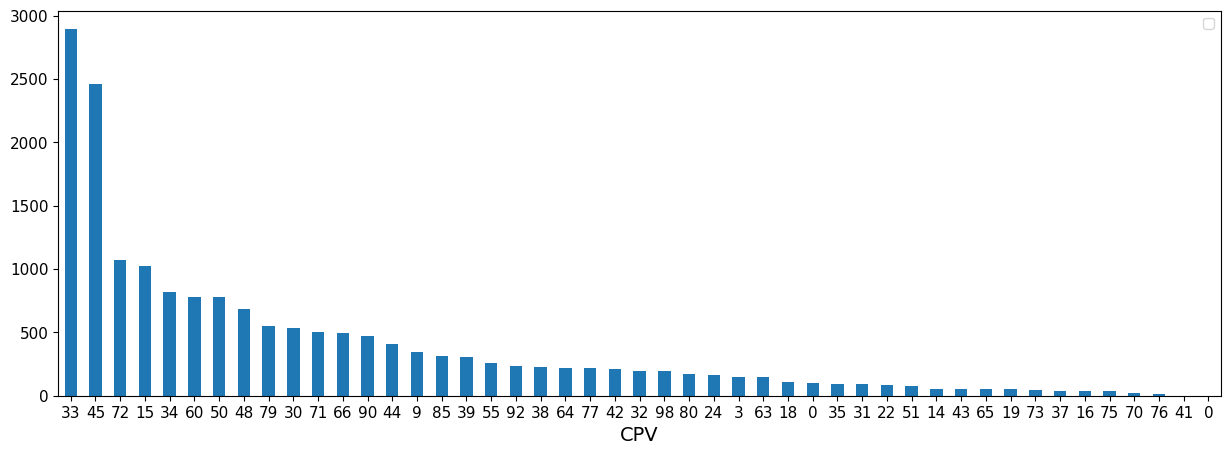

In [463]:
plt.rcParams["figure.figsize"] = (15, 5)

df = pd.DataFrame({'CPV':data1.iloc[:,0], 'val':data1.iloc[:,1]})
ax = df.plot.bar(x='CPV', y='val', rot=0, label = '')
ax.legend();
ax.set_xlabel('CPV', fontdict={'fontsize':14})
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)

#plt.savefig('/home/francisco/MECAD/2º Ano/Estágio/tese/tese_pt/imagens/r018.png', dpi = 400, bbox_inches='tight')
plt.show()

# PARTE 6 : Barplot 'R059'

In [465]:
data2 = pd.read_csv('/home/francisco/r059_barplot.csv')

In [461]:
data1.iloc[:,0] = data1.iloc[:,0].values.astype(int).astype(str)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


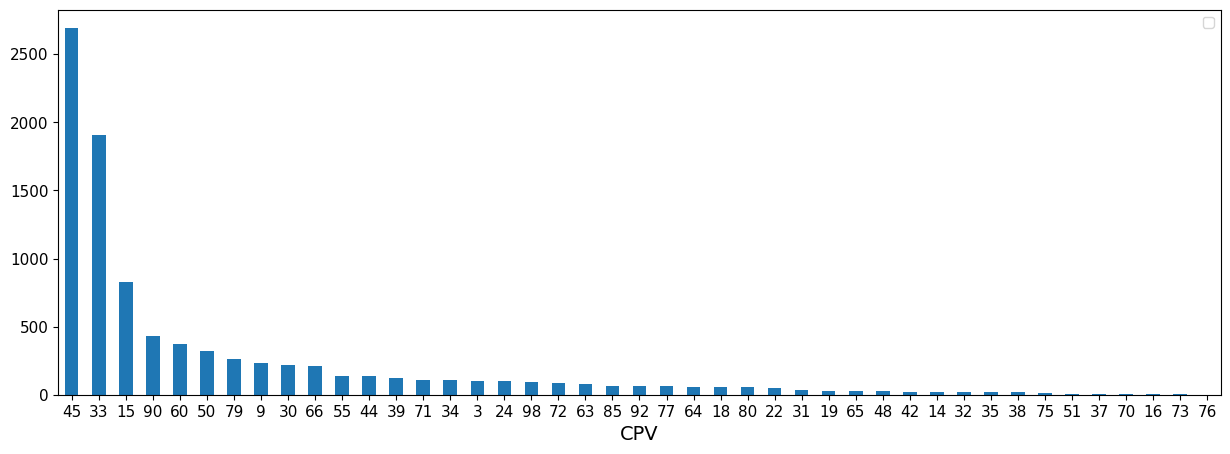

In [468]:
plt.rcParams["figure.figsize"] = (15, 5)

df = pd.DataFrame({'CPV':data2.iloc[:,0], 'val':data2.iloc[:,1]})
ax = df.plot.bar(x='CPV', y='val', rot=0, label = '')
ax.legend();
ax.set_xlabel('CPV', fontdict={'fontsize':14})
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)

#plt.savefig('/home/francisco/MECAD/2º Ano/Estágio/tese/tese_pt/imagens/r059.png', dpi = 400, bbox_inches='tight')
plt.show()

# PARTE 7 : Pie Plot Feriados

In [490]:
data3 = pd.read_csv('/home/francisco/feriado.csv')

In [494]:
d = data3.iloc[:,1].values
labels = data3.iloc[:,0].values

In [495]:
from datetime import datetime

date_strings = np.array(['12-01', '08-15', '11-01', '06-10', '12-08', '05-01', '10-05', '01-01', '04-25'])

def convert_date_format(date_str):
    date_obj = datetime.strptime(date_str, '%m-%d')
    return date_obj.strftime('%d-%m')

dd = np.vectorize(convert_date_format)(date_strings)

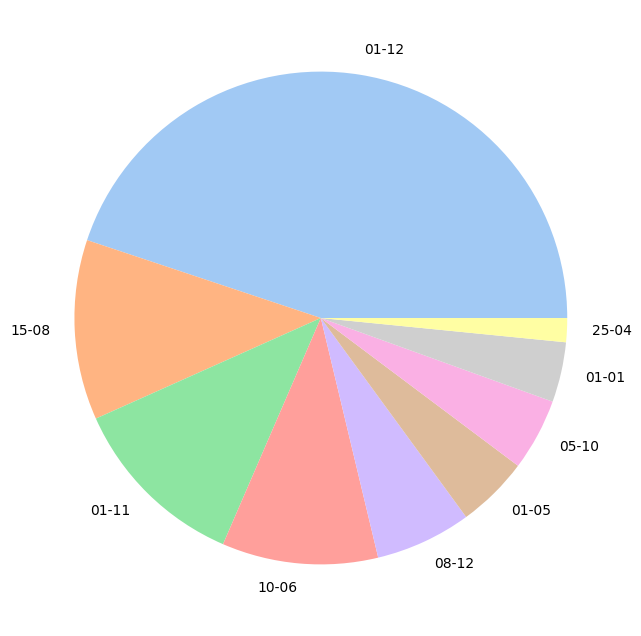

In [499]:
plt.rcParams["figure.figsize"] = (8, 8)
colors = sns.color_palette('pastel')

#create pie chart
plt.pie(d, labels = dd, colors = colors)
#plt.savefig('/home/francisco/MECAD/2º Ano/Estágio/tese/tese_pt/imagens/pieplot.png', dpi = 400, bbox_inches='tight')
plt.show()